# 모델링 및 학습

### 간단한 전처리
간단한 추천 시스템을 구현하기 위해 lightgbm으로 모델을 돌려봤습니다.  
모델을 돌리기 전에 간단한 전처리를 했습니다. 
- 카테고리 데이터의 경우: LabelEncoder후에 StandardScaler로 정규화
- 연속적인 데이터의 경우: StandardScaler로 정규화

### 모델 학습
- lightgbm으로 학습합니다. 
- feature의 중요도를 시각화 합니다. 
- 정확도를 평가합니다. 

## 간단한 전처리

In [1]:
import pandas as pd
import lightgbm as lgb
import joblib
import numpy as np 

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [4]:
data_df = pd.read_csv('./new_data/all_data_nm3.csv')

In [5]:
data_df.shape

(123095, 14)

In [6]:
data_df = data.copy()

In [7]:
data_df.columns

Index(['clnt_id', 'action_type', 'hit_pss_tm', 'sech_kwd', 'tot_pag_view_ct',
       'tot_sess_hr_v', 'trfc_src', 'dvc_ctg_nm', 'de_dt', 'buy_am', 'buy_ct',
       'clnt_gender', 'clnt_age', 'clac_nm3'],
      dtype='object')

In [8]:
data_df["action_type"] = (data_df["action_type"] == 6).astype(np.int8)

In [9]:
CATEGORICAL_COLUMNS = [ "sech_kwd", "trfc_src", "dvc_ctg_nm", 
                       "de_dt","buy_ct", "clnt_gender", "clnt_age", 'clac_nm3']

In [10]:
data_df["clac_nm3"] = data_df["clac_nm3"].astype(str)

In [11]:
for c in CATEGORICAL_COLUMNS:
    le = LabelEncoder()
    data_df[c] = le.fit_transform(data_df[c])

In [12]:
data_df.head()

,clnt_id,action_type,hit_pss_tm,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,de_dt,buy_am,buy_ct,clnt_gender,clnt_age,clac_nm3
0,49906,1,627381,0,63.0,2211.0,0,3,0,1990,1,0,2,95
1,67265,1,313631,82068,10.0,313.0,6,1,0,56900,1,0,3,448
2,68972,1,554066,82067,31.0,652.0,0,3,0,9980,2,0,4,730
3,41763,1,1241857,82066,39.0,1242.0,0,3,0,1290,1,0,3,428
4,15344,1,120487,82065,10.0,133.0,0,3,0,4100,1,0,3,9


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns


<AxesSubplot:>

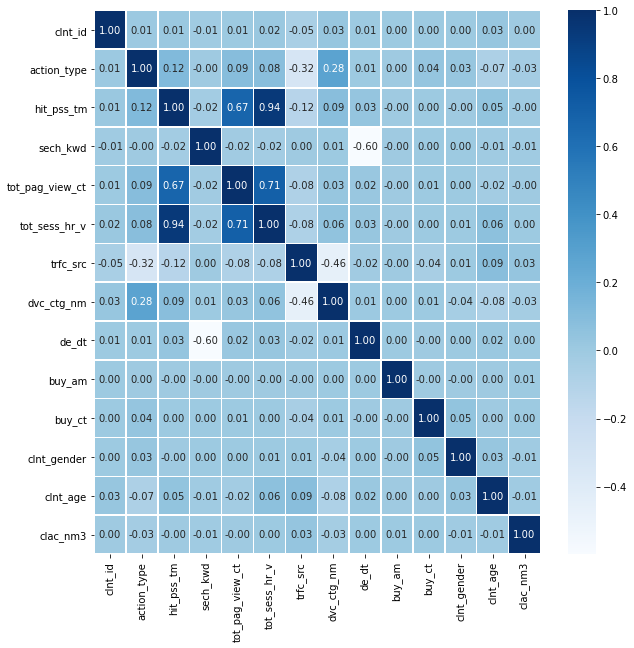

In [14]:
plt.figure(figsize=(10,10))
sns.heatmap(data = data_df.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

### Train, Test 분리

In [15]:
X = data_df.drop(['clac_nm3'], axis=1)
Y = data_df['clac_nm3']

In [16]:
X.loc[X['hit_pss_tm']==0, 'hit_pss_tm'] = 1
X.loc[X['tot_sess_hr_v']==0, 'tot_sess_hr_v'] = 1
X.loc[X['buy_am']==0, 'buy_am'] = 1

In [17]:
import math
import numpy as np

In [18]:
X['hit_pss_tm'] = X['hit_pss_tm'].apply(math.log10)

In [19]:
X['tot_sess_hr_v'] = X['tot_sess_hr_v'].astype(np.float64).apply(math.log10)
X['buy_am'] = X['buy_am'].astype('float64').apply(math.log10)

In [20]:
X

,clnt_id,action_type,hit_pss_tm,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,de_dt,buy_am,buy_ct,clnt_gender,clnt_age
0,49906,1,5.797531,0,63.0,3.344589,0,3,0,3.298853,1,0,2
1,67265,1,5.496419,82068,10.0,2.495544,6,1,0,4.755112,1,0,3
2,68972,1,5.743562,82067,31.0,2.814248,0,3,0,3.999131,2,0,4
3,41763,1,6.094072,82066,39.0,3.094122,0,3,0,3.110590,1,0,3
4,15344,1,5.080940,82065,10.0,2.123852,0,3,0,3.612784,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
123090,64811,1,6.064076,41024,34.0,3.064083,0,0,91,3.000000,1,0,4
123091,49,1,5.904764,41023,24.0,2.906335,0,3,91,3.301030,1,0,4
123092,72078,1,5.978321,41022,54.0,3.079181,0,3,91,3.599883,1,0,3
123093,39156,1,6.413662,61546,68.0,3.418964,0,3,91,2.995635,1,1,3


In [21]:
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.1, shuffle=False)

In [22]:
display(train_x.head())
train_y.head()

,clnt_id,action_type,hit_pss_tm,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,de_dt,buy_am,buy_ct,clnt_gender,clnt_age
0,49906,1,5.797531,0,63.0,3.344589,0,3,0,3.298853,1,0,2
1,67265,1,5.496419,82068,10.0,2.495544,6,1,0,4.755112,1,0,3
2,68972,1,5.743562,82067,31.0,2.814248,0,3,0,3.999131,2,0,4
3,41763,1,6.094072,82066,39.0,3.094122,0,3,0,3.110590,1,0,3
4,15344,1,5.080940,82065,10.0,2.123852,0,3,0,3.612784,1,0,3


0     95
1    448
2    730
3    428
4      9
Name: clac_nm3, dtype: int64

In [23]:
test_x.to_csv('./new_data/test_x.csv', index = False)
test_y.to_frame().reset_index(drop = True).to_csv('./new_data/test_y.csv', index = False)

In [24]:
test_y

110785    225
110786    254
110787    254
110788    410
110789     88
         ... 
123090    504
123091    871
123092    875
123093    739
123094    881
Name: clac_nm3, Length: 12310, dtype: int64

In [25]:
Y.value_counts().index

Int64Index([254, 275, 688, 337, 739, 267, 410, 221, 509,  95,
            ...
            268, 426, 682, 971, 907, 779, 746, 651, 459,  31],
           dtype='int64', length=1055)

In [26]:
train_x = train_x.drop(['clnt_id'], axis=1)

## 모델링 및 학습

In [27]:
# 파라미터 설정
params = {
    'boosting_type': 'goss',
    'objective': 'multiclass',
    'num_class':1058,
    'metric': 'softmax'
    }
predictors = train_x.columns.tolist()
dtrain = lgb.Dataset(train_x.values, label=train_y, feature_name=predictors)
dvalid = lgb.Dataset(test_x.values, label=test_y, feature_name=predictors)

dtrain

### 모델 I/O 설명

In [32]:
train_x.shape

(110785, 12)

In [30]:
train_x.head(15)

,action_type,hit_pss_tm,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,de_dt,buy_am,buy_ct,clnt_gender,clnt_age
0,1,5.797531,0,63.0,3.344589,0,3,0,3.298853,1,0,2
1,1,5.496419,82068,10.0,2.495544,6,1,0,4.755112,1,0,3
2,1,5.743562,82067,31.0,2.814248,0,3,0,3.999131,2,0,4
3,1,6.094072,82066,39.0,3.094122,0,3,0,3.110590,1,0,3
4,1,5.080940,82065,10.0,2.123852,0,3,0,3.612784,1,0,3
5,1,6.462870,82064,67.0,3.462847,0,3,0,4.401401,12,0,2
6,1,5.943970,82063,134.0,2.959518,6,1,0,4.869232,1,0,2
7,1,5.886989,82062,21.0,2.887054,0,3,0,3.475671,1,0,2
8,1,6.044500,82061,32.0,3.044540,0,3,0,3.298853,1,0,3
9,1,6.585328,82060,68.0,3.589950,4,3,0,3.110590,1,0,3


#### 인풋과 아웃풋 설명
모델의 인풋은 총 12개의 컬럼을 가진 train set입니다.  
이 모델은 총 1058개의 상품의 Prediction 값을 출력합니다.  
여기서 생각되는 문제점은 각 LOW 별 예측을 한다는 점입니다.  
즉, 각각 고객 별로 추천을 하지 못합니다.  
같은 고객이라도 다 다른 추천을 합니다.  

In [88]:
lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      early_stopping_rounds=50, # typical
                      num_boost_round=1000,
                      valid_sets=[dvalid],
                      verbose_eval=True
                     )

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

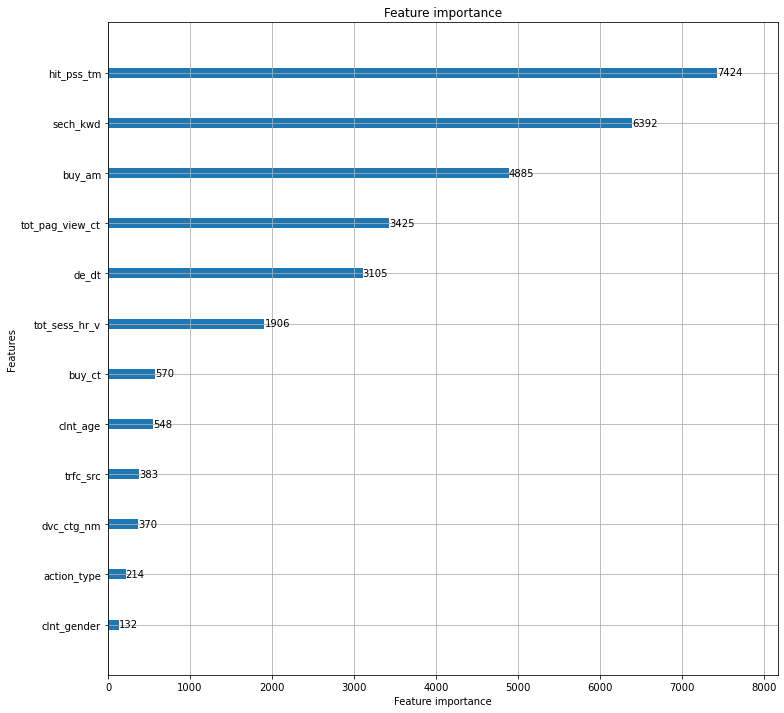

In [29]:
lgb.plot_importance(lgb_model, figsize = (12, 12))

In [30]:
joblib.dump(lgb_model, './Doc_model/lgb_model_final.pkl')

['./Doc_model/lgb_model_final.pkl']

## 모델 정확도 평가

In [31]:
lgb_model = joblib.load('./Doc_model/lgb_model_final.pkl')

In [46]:
test_x = pd.read_csv('./new_data/test_x.csv')
test_y = pd.read_csv('./new_data/test_y.csv')

In [47]:
test_x

,action_type,hit_pss_tm,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,de_dt,buy_am,buy_ct,clnt_gender,clnt_age
0,1,6.104573,36920,33.0,3.117603,0,3,82,3.567026,1,0,2
1,1,5.087579,36919,6.0,2.096910,0,3,82,3.600973,1,1,5
2,1,5.920162,36918,12.0,2.980912,4,2,82,3.600973,1,0,3
3,1,6.089007,36930,23.0,3.091315,0,3,82,3.298853,1,0,2
4,1,6.319866,36917,48.0,3.334051,4,3,82,3.995196,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
12305,1,6.064076,41024,34.0,3.064083,0,0,91,3.000000,1,0,4
12306,1,5.904764,41023,24.0,2.906335,0,3,91,3.301030,1,0,4
12307,1,5.978321,41022,54.0,3.079181,0,3,91,3.599883,1,0,3
12308,1,6.413662,61546,68.0,3.418964,0,3,91,2.995635,1,1,3


In [35]:
predict_y = lgb_model.predict(test_x)

In [140]:
predict_y.shape

(12310, 1058)

예측 결과가 아이템 개수인 1058개에 대해서 나왔습니다.  
이제 이 값으로 Top K를 정해서 정확도를 측정하겠습니다.

In [142]:
predict_y[1]

array([5.49874292e-43, 9.39436244e-42, 5.06855226e-41, ...,
       1.28082584e-53, 1.28082584e-53, 1.28082584e-53])

### 정확도 평가

In [99]:
# 정확도 측정을 위한 함수
''' 
pred_matrix: 예측된 아이템 행렬 파라미터.
top_n: 상위 몇개를 추천으로 사용할 지 정하는 파라미터.
test_matix: 고객ID와 Target이 있는 행렬 파라미터
'''
def get_acc(pred_matrix, top_n, test_matix):
    avg_acc = 0
    for i in range(len(score_matrix)):
        top = pred_matrix.iloc[i].nlargest(top_n).index
        tmp = 0
        for j in range(len(top)):
            if top[j] == test_matix["target"][i]:
                tmp += 1
        acc = tmp / len(top)
        avg_acc += acc / len(pred_matrix)

    return avg_acc

In [185]:
# 유저의 ID와 해당 유저가 구매한 아이템을 DataFrame으로 변환시켜줍니다. 
# 함수에 넣어주기 위한 기초 작업입니다. 
dic = {'clnt_id': test_x['clnt_id'],'target' : test_y}
target_matrix = pd.DataFrame(dic).reset_index()
target_matrix = target_matrix.drop(['index'], axis=1)

target_matrix.head()

,clnt_id,target
0,69386,225
1,55210,254
2,55270,254
3,16935,410
4,58068,88


In [187]:
# 고유한 item의 개수는 총 1058개 입니다. 
# 행렬 안에 있는 value는 각각의 확률이라고 생각하면 됩니다. 
# row의 행 수만큼 추천하기엔 너무 시간이 오래 걸리니 1000개로 줄여주겠습니다. 
small_p = pd.DataFrame(predict_y[:1000])
small_p.head()

,0,1,2,3,4,5,6,7,8,9,...,1048,1049,1050,1051,1052,1053,1054,1055,1056,1057
0,3.490609e-05,5.963554e-04,3.217524e-03,2.373583e-04,1.099366e-03,1.047178e-04,4.280292e-03,3.322596e-03,3.964288e-03,4.453842e-03,...,6.981231e-06,1.819010e-04,6.981231e-06,4.107260e-03,6.283085e-05,6.283085e-05,3.490609e-05,8.130699e-16,8.130699e-16,8.130699e-16
1,5.498743e-43,9.394362e-42,5.068552e-41,3.739096e-42,1.731826e-41,1.649615e-42,3.468047e-40,5.234073e-41,6.244928e-41,7.016119e-41,...,1.099751e-43,2.865479e-42,1.099751e-43,6.470151e-41,9.897719e-43,9.897719e-43,5.498743e-43,1.280826e-53,1.280826e-53,1.280826e-53
2,7.655848e-06,1.307968e-04,7.056897e-04,5.205908e-05,2.411205e-04,2.296744e-05,4.828529e-03,7.287350e-04,8.694754e-04,9.768476e-04,...,1.531172e-06,3.989579e-05,1.531172e-06,9.008330e-04,1.378050e-05,1.378050e-05,7.655848e-06,1.783282e-16,1.783282e-16,1.783282e-16
3,3.146493e-05,5.375647e-04,2.900330e-03,2.139588e-04,9.909865e-04,9.439438e-05,3.858327e-03,2.995044e-03,3.640405e-03,4.014767e-03,...,6.292998e-06,1.639686e-04,6.292998e-06,3.702353e-03,5.663678e-05,5.663678e-05,3.146493e-05,7.329148e-16,7.329148e-16,7.329148e-16
4,1.197158e-09,2.045292e-08,1.117941e-07,8.140568e-09,3.786250e-08,3.591458e-09,1.475966e-07,1.139535e-07,1.359614e-07,1.451926e-07,...,2.394320e-10,6.238573e-09,2.394320e-10,1.738876e-07,2.154880e-09,2.154880e-09,1.197158e-09,2.788548e-20,2.788548e-20,2.788548e-20


In [188]:
accuracy = get_acc(small_p, 5, target_matrix)
print(f"정확도: {accuracy*100}%")

정확도: 5.599999999999977%


총 5.6% 의 정확도가 나왔습니다.  
하지만 5개를 추천했을 때 구매수는 1개 이므로 최대값이 20%입니다.  
그러므로 5.6 x 5 = 28% 정도 됩니다. 

### 추천된 상품 확인 함수

In [105]:
small_d = data_df['clac_nm3'][:300]
small_y = Y[:300]

d={'hangle': small_d, 'label': small_y}
df = pd.DataFrame(data=d)
cate2papago = df.set_index('label').to_dict()

In [106]:
def get_pred_list(predict_y, top_n, target_matrix, columns):
    test_matrix = target_matrix.copy()
    pred_matrix = predict_y.copy()
    pred_matrix.rename(columns = columns['hangle'], inplace = True)
    for i in range(len(pred_matrix)):
        top = pred_matrix.iloc[i].nlargest(top_n).index
        top = pd.DataFrame(top.astype(str).to_frame().apply(lambda x: ", ".join(x)))
        test_matrix.loc[i, 'pred'] = top.values
    test_matrix['target'] = test_matrix['target'].apply(lambda x: columns['hangle'][x])
    return test_matrix

In [135]:
d={'hangle': data['clac_nm3'], 'label': data_df['clac_nm3']}
df = pd.DataFrame(data=d).drop_duplicates()
cate2papago = df.set_index('label').to_dict()

In [189]:
test = get_pred_list(small_p, 5, target_matrix, cate2papago)

test[test['pred'].notna()]

,clnt_id,target,pred
0,69386,냉이떡,"[샌드 쿠키, 냉면, 달걀, 라면, 우유]"
1,55210,달걀,"[유아/유아 한복, 기타 키즈 슈즈, 베이스볼 캡스, 봄 양파, 냉장 숙성 소스]"
2,55270,달걀,"[녹말 시럽 / 시럽, 다른 냉동 과일, 달걀, Chickins 찜 매운 Soups..."
3,16935,비빔 라면,"[토핑을 곁들인 즉석 밥그릇, 달걀, 라면, 우유, 물]"
4,58068,귤,"[에어프레셔스, 냉장 다과, 달걀, 라면, 우유]"
...,...,...,...
995,34707,인스턴트 큐브 라이스,"[베이비 포뮬러, 마닐라 바지락, 달걀, 라면, 우유]"
996,11418,우유,"[스위트 팥 젤리, 헤어 린스 / 컨디셔너, 우유, 달걀, 라면]"
997,32776,감자 스낵,"[Canned 기타 육류 식품, 마닐라 바지락, 새송이버섯, 일반 스낵, 혼합 과일..."
998,23755,오이,"[달걀, 라면, 우유, 물, 두부]"


위의 함수를 통해 어떤 상품이 추천 되는지 볼 수 있습니다.  
하지만 한가지 문제 점이 있습니다. 

In [199]:
print('상위 50개 제품의 구매 수: ', data['clac_nm3'].value_counts()[:50].sum())
print('전체 제품(1058개)의 구매 수: ', data['clac_nm3'].shape[0])
print('전체 제품 대비 상위 50개 비율', round((data['clac_nm3'].value_counts()[:50].sum()/ data['clac_nm3'].shape[0])*100, 2), '%')

상위 50개 제품의 구매 수:  63565
전체 제품(1058개)의 구매 수:  123095
전체 제품 대비 상위 50개 비율 51.64 %


전체 제품의 종류는 1058개나 되는데 50개의 품목이 구매량의 절반을 차지합니다.  
즉 50개에 중점적으로 추천을 하게 되면 정답률이 많이 올라가게 됩니다. 

이 문제는 Wide & Deep 모델에서 Focal loss를 사용하므로써 해결해보았습니다. 